In [ ]:
import numpy as np

import cv2

import matplotlib.pyplot as plt

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch

from tqdm import tqdm

from models.ResNet18TL import CustomResNet18

In [32]:
device = (torch.device(f"cuda:0") if torch.cuda.is_available() else torch.device("cpu"))

In [33]:
def plot_images(random_batch, k, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    images, labels = random_batch
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)

    for index in range(k):
        image = images[index] * std + mean
        image = np.clip(image.numpy(), 0, 1)  
        
        plt.figure()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(f"Image label: {labels[index]}")

def get_predictions(model, eval_data, step=10):
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim = 1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim = 1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score

In [34]:
train_transform = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_transform = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

train_dataset = CIFAR10(
    root='./data', 
    train=True,
    download=False, 
    transform=train_transform  
)

test_dataset = CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=test_transform
)

train_len = int(0.9 * len(train_dataset))
val_len = len(train_dataset) - train_len

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_len, val_len], generator=generator)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=128, shuffle=True, num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=0
)

Размерность: torch.Size([3, 224, 224])


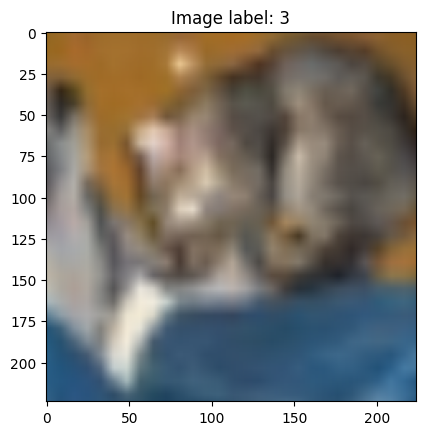

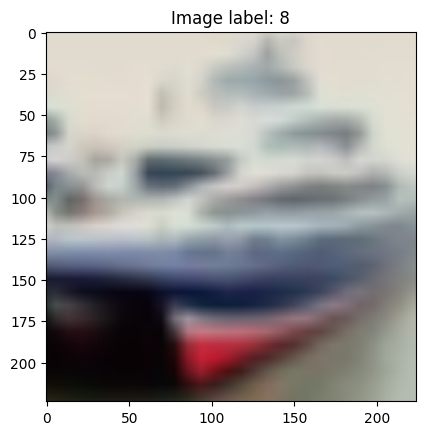

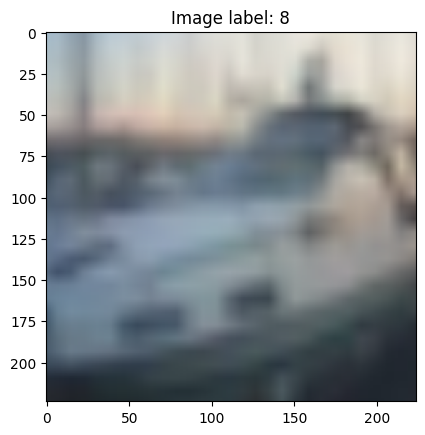

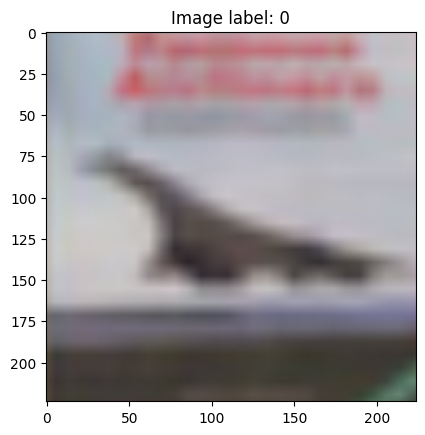

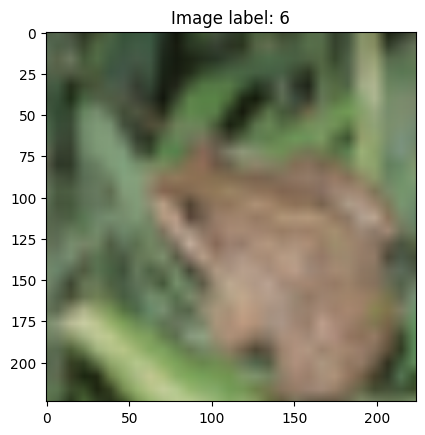

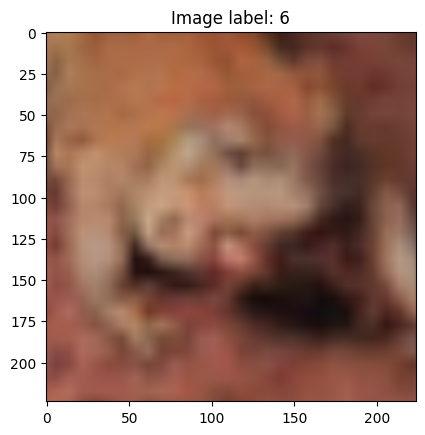

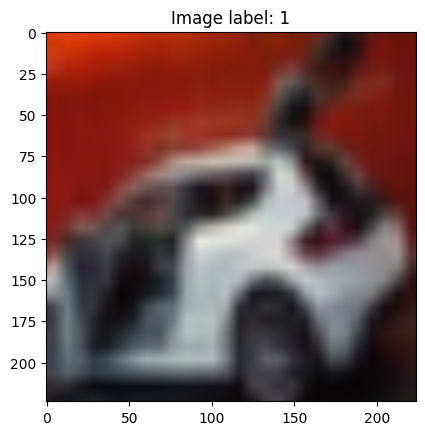

In [35]:
k = 7

random_batch = next(iter(test_data_loader))
plot_images(random_batch, k)

print("Размерность:", random_batch[0][k].shape)

In [36]:
ResNet = CustomResNet18()
Model_3 = ResNet.get_model()

Model_3.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [37]:
Model_3_train_accuracy = get_accuracy(Model_3, train_data_loader)

print("Точность на обучающей выборке:", Model_3_train_accuracy)

Точность на обучающей выборке: tensor(0.1010)


### Точность точно такая же, как и у случайного классификатора. Так и должно быть, ведь мы не обучили слои модели.

### Обучим модель

In [38]:
Model_3.train_model(train_data_loader, device, val_data_loader = val_data_loader, num_epoches = 25)

  0%|          | 0/25 [00:00<?, ?it/s]

Train - 0:0.7269731096246026


  4%|▍         | 1/25 [02:49<1:07:39, 169.14s/it]

Val - 0:0.5488433919847011
Train - 1:0.4396308022974567


  8%|▊         | 2/25 [07:05<1:24:36, 220.74s/it]

Val - 1:0.4002347946166992
Train - 2:0.3555496378632432


 12%|█▏        | 3/25 [11:12<1:25:19, 232.69s/it]

Val - 2:0.3877590037882328
Train - 3:0.29993990939957177


 16%|█▌        | 4/25 [13:45<1:10:21, 201.01s/it]

Val - 3:0.3066462676972151
Train - 4:0.25989124763079663


 20%|██        | 5/25 [15:50<57:51, 173.55s/it]  

Val - 4:0.3357687443494797
Train - 5:0.23292340391146188


 24%|██▍       | 6/25 [17:55<49:46, 157.16s/it]

Val - 5:0.3031995505094528
Train - 6:0.20997943166135388


 28%|██▊       | 7/25 [19:50<42:57, 143.20s/it]

Val - 6:0.27564519345760347
Train - 7:0.17929198255296797


 32%|███▏      | 8/25 [21:43<37:52, 133.68s/it]

Val - 7:0.2779909536242485
Train - 8:0.15532976793209938


 36%|███▌      | 9/25 [23:37<33:58, 127.43s/it]

Val - 8:0.2581243343651295
Train - 9:0.136242588177662


 40%|████      | 10/25 [25:30<30:45, 123.04s/it]

Val - 9:0.2589040003716946
Train - 10:0.11977364227112214


 44%|████▍     | 11/25 [27:23<28:02, 120.21s/it]

Val - 10:0.24308579098433256
Train - 11:0.10339724017434161


 48%|████▊     | 12/25 [29:17<25:34, 118.02s/it]

Val - 11:0.24782956577837467
Train - 12:0.08653519043847072


 52%|█████▏    | 13/25 [31:10<23:19, 116.65s/it]

Val - 12:0.24098092671483756
Train - 13:0.07362437032861635


 56%|█████▌    | 14/25 [33:04<21:13, 115.76s/it]

Val - 13:0.25026501826941966
Train - 14:0.06050581272310493


 60%|██████    | 15/25 [34:57<19:11, 115.16s/it]

Val - 14:0.2260939789470285
Train - 15:0.049249704638813535


 64%|██████▍   | 16/25 [36:51<17:12, 114.69s/it]

Val - 15:0.22648085814435034
Train - 16:0.04232271801315206


 68%|██████▊   | 17/25 [38:47<15:19, 114.95s/it]

Val - 16:0.204889409232419
Train - 17:0.03559521313515936


 72%|███████▏  | 18/25 [40:49<13:39, 117.05s/it]

Val - 17:0.2298071790486574
Train - 18:0.025903241133743326


 76%|███████▌  | 19/25 [42:45<11:40, 116.81s/it]

Val - 18:0.22403208063915372
Train - 19:0.023250398142078087


 80%|████████  | 20/25 [47:21<13:43, 164.73s/it]

Val - 19:0.2313402395695448
Train - 20:0.01888355296647536


 84%|████████▍ | 21/25 [48:49<09:27, 141.77s/it]

Val - 20:0.2328284526243806
Train - 21:0.014783104071367152


 88%|████████▊ | 22/25 [50:18<06:17, 125.70s/it]

Val - 21:0.22411210788413882
Train - 22:0.016337681218084817


 92%|█████████▏| 23/25 [51:46<03:48, 114.43s/it]

Val - 22:0.21833596762735397
Train - 23:0.01488971809058884


 96%|█████████▌| 24/25 [53:14<01:46, 106.61s/it]

Val - 23:0.2236603803932667
Train - 24:0.013342309990052441


100%|██████████| 25/25 [54:42<00:00, 131.30s/it]

Val - 24:0.21382656190544366


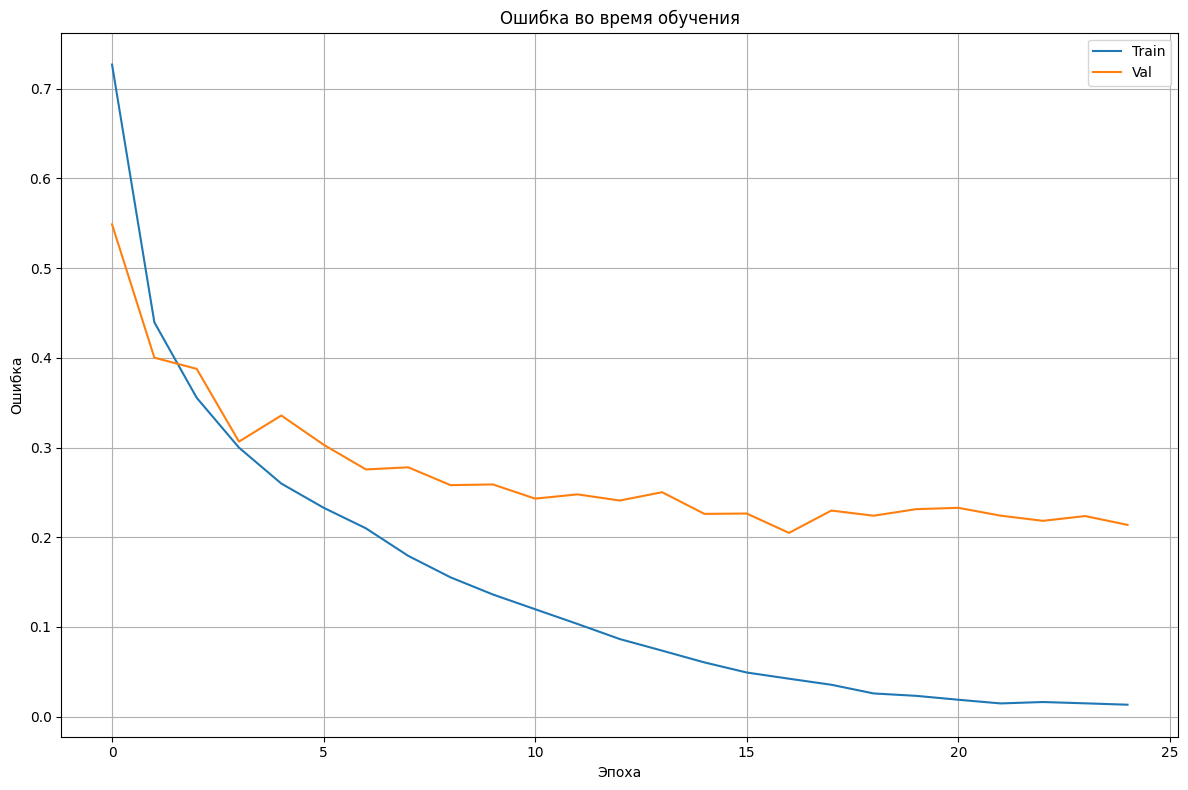

In [39]:
Model_3.plot_loss()

In [40]:
Model_3_train_accuracy = get_accuracy(Model_3, train_data_loader)
Model_3_val_accuracy = get_accuracy(Model_3, val_data_loader)

print("Точность на обучающей выборке:", Model_3_train_accuracy)
print("Точность на валидационной выборке:", Model_3_val_accuracy)

Точность на обучающей выборке: tensor(0.9979)
Точность на валидационной выборке: tensor(0.9438)


In [41]:
torch.save(Model_3.state_dict(), 'models/model_3_w.pth')
torch.save(Model_3, 'models/model_3.pth')